# Estimating the cost of apartments in Moscow using Python
The real estate market in Moscow is very extensive. At the moment, there are tens of thousands of apartments for sale: from affordable apartments near the Moscow Ring Road to penthouses in the city center. Such diversity of supply can make this market attractive for Data Scientists to explore.

**Tasks**:  
1. collect a dataset of apartments in Moscow
1. explore publicly available factors affecting the final price of an apartment
1. implement a machine learning model on the collected data (train and test the accuracy of estimates)

Parser class structure

In [1]:
class Parser:
    def __init__(self, url, pages, output_file_name):
        self.url = url
        self.pages = pages
        self.driver = self.init_driver()
        self.output_file_name = output_file_name

        self.create_dataframe()
        self.driver.quit()
  
    def init_driver(self):
        ...
  
    def create_dataframe(self):
        ...
    
    def parse(self):
        ...
  
    def clean(self, data):
        ...
    
  
    

Used version of Python: 3.10.4

In [2]:
import sys
print(sys.version)

3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]


Import libraries: pandas, sklearn, xgboost

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

Load DataFrame and get its shape, as well as statistics on fields of a numeric type

In [4]:
data = pd.read_csv("data_extended_2.csv")
data.head()

,meters,address,latitude,longitude,title,price_per_meter,price,floor,floors,metro,metro_distance,metro_distance_type,building,rooms,is_flat,description
0,12.700000,"Вольная улица, 25",55.777070,37.732945,"12,7 м², апартаменты-студия",312180,3964686,1,2,Семёновская,17,0,1 этаж из 2,0,False,Субсидированная ипотека от ведущих банков Отде...
1,951.999992,"Гранатный переулок, 8с4",55.760030,37.590863,"952 м², 13-комнатные апартаменты",1976750,1881865984,8,8,Баррикадная,11,0,"ЖК «Гранатный Палас», 8 этаж из 8",3,False,Лот: 11121. В продаже видовой пентхаус с терра...
2,21.400001,"поселение Сосенское, жилой комплекс Прокшино",55.571900,37.445617,"21,4 м², квартира-студия",329837,7058512,5,9,Прокшино,18,0,"новостройка, ЖК «Прокшино» 3 кв. 2024 г., 5 эт...",0,True,"Apт.1684014. Гибкая ипотека от 0,1%! Вы можете..."
3,38.790000,жилой комплекс Симфония 34,55.568301,37.592959,"38,8 м², 1-комнатная квартира",513200,19907028,18,36,Дмитровская,9,0,"новостройка, ЖК Symphony 34 2025 г., 18 этаж и...",1,True,Продаётся 1-комнатная квартира от застройщика ...
4,120.199895,"шоссе Энтузиастов, 3Ак1",55.776238,37.839417,"120,2 м², 4-комнатная квартира",380200,45700000,14,21,Москва Товарная,13,0,"новостройка, Квартал «Символ» 2023 г., 14 этаж...",4,True,Продаю просторную квартиру с европланировкой п...


The data set consists of more than 6.5 thousand records and includes data on the area of ​​the apartment, location, price per square meter, total price, floor, number of floors in the house, metro station, distance to the station (in minutes, on foot or by transport), number rooms, as well as the type of housing (flat / apartment)

In [5]:
data.shape

(6748, 16)

In [6]:
data.describe()

,meters,latitude,longitude,price_per_meter,price,floor,floors,metro_distance,metro_distance_type,rooms
count,6748.000000,5969.000000,5969.000000,6.748000e+03,6.748000e+03,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000
mean,64.344889,55.742980,37.569619,4.269879e+05,3.912311e+07,7.902786,16.185536,11.626260,0.109662,1.963248
std,52.061817,0.112464,0.161619,4.253814e+05,9.383000e+07,7.269487,11.080072,4.738507,0.312491,1.241236
min,8.700008,55.096123,36.920921,7.873200e+04,2.990000e+06,1.000000,1.000000,1.000000,0.000000,0.000000
25%,36.470089,55.674560,37.525231,2.613640e+05,1.050000e+07,3.000000,8.000000,8.000000,0.000000,1.000000
50%,51.400030,55.759618,37.593211,3.269000e+05,1.471925e+07,5.000000,13.000000,12.000000,0.000000,2.000000
75%,68.699944,55.809022,37.637773,4.480550e+05,2.700000e+07,11.000000,25.000000,15.000000,0.000000,3.000000
max,951.999992,56.155797,38.930808,5.675511e+06,2.000050e+09,54.000000,77.000000,53.000000,1.000000,9.000000


In [7]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

A plot of the dependence of the price on the area of the apartment

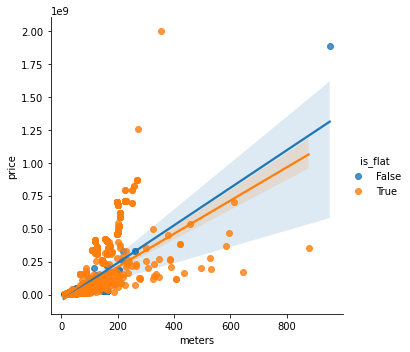

In [8]:
sns.lmplot(x="meters", y="price", hue="is_flat", data=data)

As can be seen from the graph, there are rare cases in the data set with an apartment area of ​​more than 300 square meters, as well as too high a price. Such exceptions negatively affect the accuracy of the future model estimation. Therefore, we remove some sentences from the set.

In [9]:
data = data.drop(data[data.meters > 300].index)

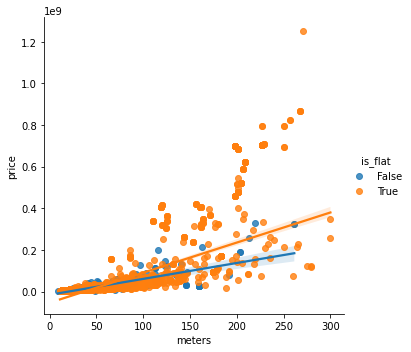

In [10]:
sns.lmplot(x="meters", y="price", hue="is_flat", data=data)

In [11]:
data = data.drop(data[data.price > 350000000].index)

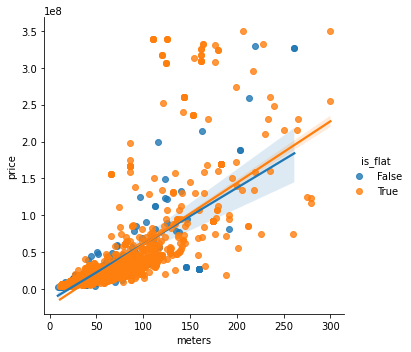

In [12]:
sns.lmplot(x="meters", y="price", hue="is_flat", data=data)

The dependence in the graph has become more straight with a smaller spread of values

During the creation of the dataset, some addresses could not be located. Therefore, we will replace the missing values with the location of the nearest metro station

In [13]:
coord_data = data.copy()
coord_data.isnull().sum()

meters                   0
address                  0
latitude               778
longitude              778
title                    0
price_per_meter          0
price                    0
floor                    0
floors                   0
metro                    0
metro_distance           0
metro_distance_type      0
building                 0
rooms                    0
is_flat                  0
description            264
dtype: int64

Get the names of metro stations for records in which there are no longitude and latitude values. Then go through the list of stations and get their coordinates, and then fill in the missing values.

In [14]:
from geopy.geocoders import Nominatim
geocoder = Nominatim(user_agent="mskapp")

def get_missing_coordinates(coord_data):
    missing_coords_by_metro = coord_data.loc[coord_data['longitude'].isna()].metro
    metro_coords = {}
    seen_stations = []
    for m in missing_coords_by_metro:
        if m not in seen_stations:
            try:
                coords = geocoder.geocode(f"Москва, станция {m}")
                seen_stations.append(m)
                metro_coords[m] = (coords.longitude, coords.latitude)
            except AttributeError as e:
                print("unknown metro station")
    return metro_coords
    
metro_coords = get_missing_coordinates()
for metro, coords in metro_coords.items():
    coord_data.loc[(coord_data['longitude'].isna()) & (coord_data["metro"] == metro), "longitude"] = coords[0]
    coord_data.loc[(coord_data['latitude'].isna()) & (coord_data["metro"] == metro), "latitude"] = coords[1]
        
coord_data.isnull().sum()

meters                   0
address                  0
latitude                 0
longitude                0
title                    0
price_per_meter          0
price                    0
floor                    0
floors                   0
metro                    0
metro_distance           0
metro_distance_type      0
building                 0
rooms                    0
is_flat                  0
description            264
dtype: int64

Let's find the deviation of the location of the apartment from the city center (we consider Red Square as the city center), and then find the distance to the center (according to the Pythagorean theorem).

In [15]:
# coordinates relatively to the city centre
coord_data.longitude -= 37.62167272350393
coord_data.latitude -= 55.754015656147125
coord_data["distance"] = (((coord_data.longitude * 111.3) ** 2) + ((coord_data.latitude * 111.3) ** 2)) ** 0.5
coord_data.head()

,meters,address,latitude,longitude,title,price_per_meter,price,floor,floors,metro,metro_distance,metro_distance_type,building,rooms,is_flat,description,distance
0,12.700000,"Вольная улица, 25",0.023054,0.111272,"12,7 м², апартаменты-студия",312180,3964686,1,2,Семёновская,17,0,1 этаж из 2,0,False,Субсидированная ипотека от ведущих банков Отде...,12.647600
2,21.400001,"поселение Сосенское, жилой комплекс Прокшино",-0.182116,-0.176056,"21,4 м², квартира-студия",329837,7058512,5,9,Прокшино,18,0,"новостройка, ЖК «Прокшино» 3 кв. 2024 г., 5 эт...",0,True,"Apт.1684014. Гибкая ипотека от 0,1%! Вы можете...",28.192514
3,38.790000,жилой комплекс Симфония 34,-0.185715,-0.028713,"38,8 м², 1-комнатная квартира",513200,19907028,18,36,Дмитровская,9,0,"новостройка, ЖК Symphony 34 2025 г., 18 этаж и...",1,True,Продаётся 1-комнатная квартира от застройщика ...,20.915631
4,120.199895,"шоссе Энтузиастов, 3Ак1",0.022223,0.217745,"120,2 м², 4-комнатная квартира",380200,45700000,14,21,Москва Товарная,13,0,"новостройка, Квартал «Символ» 2023 г., 14 этаж...",4,True,Продаю просторную квартиру с европланировкой п...,24.360870
5,19.000000,"Балтийская улица, 15",0.056696,-0.107335,"19 м², апартаменты-студия",300000,5700000,9,14,Сокол,9,0,9 этаж из 14,0,False,Субсидированная ипотека от ведущих банков. Про...,13.510579


Let's add the geographical direction of the apartment location to the dataset. There are only four directions *checк the picture*
<img src="imgs/2.png" width="500">

In [16]:
def direction(long, lat):
    if (long > 0) and (lat > 0):
        return 1
    if (long > 0) and (lat < 0):
        return 2
    if (long < 0) and (lat > 0):
        return 3
    if (long < 0) and (lat < 0):
        return 4
coord_data["zone"] = coord_data.apply(lambda x: direction(x['longitude'], x['latitude']), axis=1)

In [17]:
coord_data.describe()

,meters,latitude,longitude,price_per_meter,price,floor,floors,metro_distance,metro_distance_type,rooms,distance,zone
count,6593.000000,6593.000000,6593.000000,6.593000e+03,6.593000e+03,6593.000000,6593.000000,6593.000000,6593.000000,6593.000000,6593.000000,6593.000000
mean,60.174365,-0.006774,-0.049401,3.775154e+05,2.750182e+07,7.871075,16.249659,11.737752,0.111330,1.912938,15.774919,2.796147
std,40.441012,0.107824,0.157129,2.361251e+05,4.105475e+07,7.293979,11.170248,4.720873,0.314564,1.195412,15.224481,1.045682
min,8.700008,-0.657893,-0.700752,7.873200e+04,2.990000e+06,1.000000,1.000000,1.000000,0.000000,0.000000,0.611654,1.000000
25%,36.470089,-0.069891,-0.096795,2.613640e+05,1.020000e+07,3.000000,8.000000,8.000000,0.000000,1.000000,7.997878,2.000000
50%,49.400029,0.006454,-0.028043,3.242970e+05,1.450000e+07,5.000000,12.000000,12.000000,0.000000,2.000000,11.419574,3.000000
75%,67.499998,0.055005,0.016101,4.270000e+05,2.583143e+07,11.000000,25.000000,15.000000,0.000000,3.000000,18.847630,4.000000
max,300.000000,0.401781,1.309135,3.077405e+06,3.500000e+08,54.000000,77.000000,53.000000,1.000000,8.000000,146.056596,4.000000


<AxesSubplot:xlabel='is_flat', ylabel='count'>

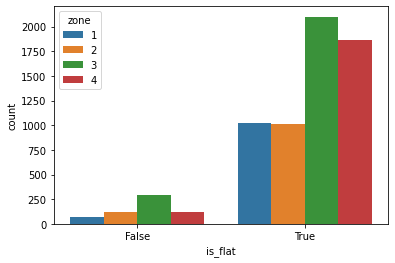

In [18]:
sns.countplot(x="is_flat", hue="zone", data=coord_data)

This histogram reflects the lack of the collected data set: the amount of information about offers in the west of Moscow is many times greater than in the east, which can affect the accuracy of the estimate

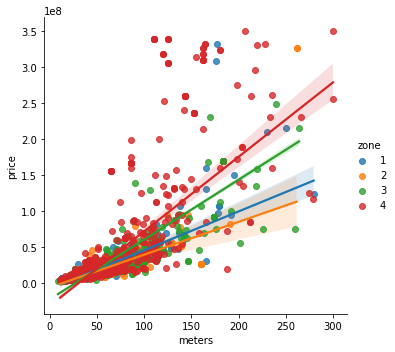

In [19]:
sns.lmplot(x="meters", y="price", hue="zone", data=coord_data)

This graph shows that the average price of apartments in the fourth and third directions (West) is higher than in the 1st and 2nd directions.

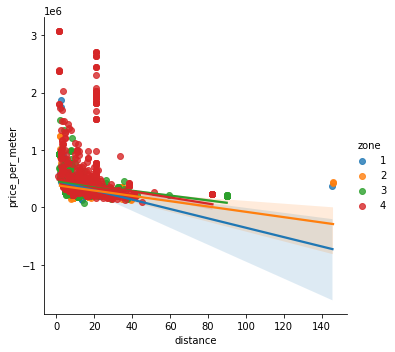

In [20]:
sns.lmplot(x="distance", y="price_per_meter", hue="zone", data=coord_data)

It can also be seen that, at a distance from the city center, proposals in the 3rd and 4th directions lose in value the prices per square meter of area more slowly than in the eastern directions.

In [21]:
coord_data = coord_data.drop(coord_data[coord_data.distance > 60].index)

Delete records with a distance from the center of more than 60 kilometers

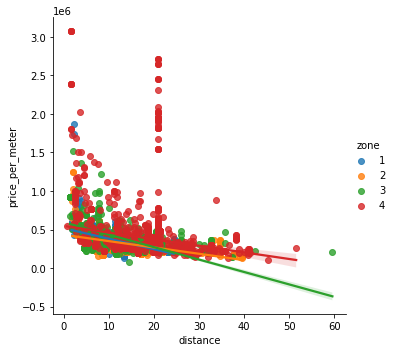

In [22]:
sns.lmplot(x="distance", y="price_per_meter", hue="zone", data=coord_data)

In [23]:
coord_data["is_flat"] = coord_data["is_flat"].astype(int)
coord_data['metro'] = coord_data['metro'].astype('category')
coord_data['metro_code'] = coord_data['metro'].cat.codes

Let's replace the boolean data type with a numeric one: *True/False -> 1/0*. Also, to train the model, we will use only the numeric data type, as a result of which we will encode all the names of metro stations into numeric codes.

In [24]:
coord_data.head()

,meters,address,latitude,longitude,title,price_per_meter,price,floor,floors,metro,metro_distance,metro_distance_type,building,rooms,is_flat,description,distance,zone,metro_code
0,12.700000,"Вольная улица, 25",0.023054,0.111272,"12,7 м², апартаменты-студия",312180,3964686,1,2,Семёновская,17,0,1 этаж из 2,0,0,Субсидированная ипотека от ведущих банков Отде...,12.647600,1,174
2,21.400001,"поселение Сосенское, жилой комплекс Прокшино",-0.182116,-0.176056,"21,4 м², квартира-студия",329837,7058512,5,9,Прокшино,18,0,"новостройка, ЖК «Прокшино» 3 кв. 2024 г., 5 эт...",0,1,"Apт.1684014. Гибкая ипотека от 0,1%! Вы можете...",28.192514,4,155
3,38.790000,жилой комплекс Симфония 34,-0.185715,-0.028713,"38,8 м², 1-комнатная квартира",513200,19907028,18,36,Дмитровская,9,0,"новостройка, ЖК Symphony 34 2025 г., 18 этаж и...",1,1,Продаётся 1-комнатная квартира от застройщика ...,20.915631,4,45
4,120.199895,"шоссе Энтузиастов, 3Ак1",0.022223,0.217745,"120,2 м², 4-комнатная квартира",380200,45700000,14,21,Москва Товарная,13,0,"новостройка, Квартал «Символ» 2023 г., 14 этаж...",4,1,Продаю просторную квартиру с европланировкой п...,24.360870,1,109
5,19.000000,"Балтийская улица, 15",0.056696,-0.107335,"19 м², апартаменты-студия",300000,5700000,9,14,Сокол,9,0,9 этаж из 14,0,0,Субсидированная ипотека от ведущих банков. Про...,13.510579,3,180


Let's prepare the data for training the model. Let's create a variable X by cutting out the price values from it (because they will be used as the goal of the assessment), and then inserting them into the variable y.
Let's divide the data set into two parts in the ratio 80/20: for training and for validating the model

In [25]:
train_data = coord_data.copy()
print(train_data.shape)
y = train_data.pop("price")
train_data.pop("price_per_meter")
X = train_data

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y,
                                                                random_state=0,
                                                                train_size=0.8,
                                                                test_size=0.2)
features = ["meters", "floor", "floors", "metro_code", "metro_distance_type", 
            "metro_distance", "rooms", "is_flat", "distance", "latitude", "longitude", "zone"]
X_train = X_train_full[features].copy()
X_valid = X_valid_full[features].copy()

print(f"Features: {features}")

(6388, 19)
Features: ['meters', 'floor', 'floors', 'metro_code', 'metro_distance_type', 'metro_distance', 'rooms', 'is_flat', 'distance', 'latitude', 'longitude', 'zone']


Empirically approached the coefficients for the models, the estimated estimate of the model (mean absolute error - MAE)

In [26]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.02, n_jobs=12)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=12, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

Test the trained model separately in the western and eastern directions, and then get the average error after cross-validation

In [29]:
train_data = coord_data.copy()
train_data = train_data[train_data["zone"] >= 3]
print(train_data.shape)
y = train_data.pop("price")
train_data.pop("price_per_meter")
X = train_data

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y,
                                                                random_state=0,
                                                                train_size=0.8,
                                                                test_size=0.2)
X_train = X_train_full[features].copy()
X_valid = X_valid_full[features].copy()


preds = model.predict(X_valid)
score = mean_absolute_error(y_valid, preds)
print("Average MAE score (only zones 3 and 4):")
print(score)

train_data = coord_data.copy()
train_data = train_data[train_data["zone"] <= 2]
print(train_data.shape)
y = train_data.pop("price")
train_data.pop("price_per_meter")
X = train_data

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y,
                                                                random_state=0,
                                                                train_size=0.8,
                                                                test_size=0.2)
X_train = X_train_full[features].copy()
X_valid = X_valid_full[features].copy()


preds = model.predict(X_valid)
score = mean_absolute_error(y_valid, preds)
print("Average MAE score (only zones 1 and 2):")
print(score)

# scores = -1 * cross_val_score(model, X_train, y_train, 
#                               cv=5, scoring="neg_mean_absolute_error")
# print("Average MAE score:")
# print(scores.mean())

scores = -1 * cross_val_score(model, X_train, y_train, 
                              cv=5, scoring="neg_mean_absolute_error")
print("Average MAE score:")
print(scores.mean())

(4164, 19)
Average MAE score (only zones 3 and 4):
514120.81032412965
(2224, 19)
Average MAE score (only zones 1 and 2):
960988.7438202248
Average MAE score:
1010536.9174090046


(4164, 19) <br>
Average MAE score (only zones 3 and 4): <br>
514120.81032412965 <br>
(2224, 19) <br>
Average MAE score (only zones 1 and 2): <br>
960988.7438202248 <br>
Average MAE score: <br>
1010536.9174090046*

It follows from the results that the model performs much better on western data. The average error in the estimate was +- 1 million. rub. It is possible to greatly improve the result by collecting a dataset of sizes over 10,000 records, which is critical in real apartment appraisal projects, but the current dataset is quite suitable for educational purposes.